<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#description" data-toc-modified-id="description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>description</a></span></li><li><span><a href="#Import" data-toc-modified-id="Import-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import</a></span><ul class="toc-item"><li><span><a href="#external-library" data-toc-modified-id="external-library-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>external library</a></span></li><li><span><a href="#my-function" data-toc-modified-id="my-function-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>my function</a></span></li></ul></li><li><span><a href="#input-for-the-code" data-toc-modified-id="input-for-the-code-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>input for the code</a></span><ul class="toc-item"><li><span><a href="#load-the-microstructure" data-toc-modified-id="load-the-microstructure-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>load the microstructure</a></span></li></ul></li><li><span><a href="#run-the-code" data-toc-modified-id="run-the-code-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>run the code</a></span></li><li><span><a href="#save-results" data-toc-modified-id="save-results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>save results</a></span></li><li><span><a href="#load-the-results" data-toc-modified-id="load-the-results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>load the results</a></span></li></ul></div>

# Phase-field model for growth and coarsening of Si precipitate in AlSi10Mg SLM in a super-saturated matrix
This model is based on the Kim-Kim-Suzuki model [1]
References:


[1] Kim, Kim, and Suzuki. "Phase-field model for binary alloys." Physical Review E 60:6;7186-7197 (1999).


# Import

## external library

In [121]:
import os
import numpy as np
import importlib
import collections
from os import chdir
from scipy.interpolate import UnivariateSpline #pour ma spline
import sys
import random
import importlib
from scipy.interpolate import splev, splrep
from itertools import cycle
import pyFi_adapt
importlib.reload(pyFi_adapt)
from pyFi_adapt import *
import pyvista as pv
import matplotlib.pyplot as plt


# input for the code

In [122]:
# 2 precipitates , small grid

# grid dimension
# points
Nx = 1100
Ny = 1100

Nz =1  # Nz=1 -> 2D 
# spacing
dx=  0.345*1e-9 # [m]

dy= 1*dx      # [m]

dz= dx # [m]


### new grid 

In [123]:
micro=np.load("micro_final.npz")

In [124]:
xyz_r=np.asarray([micro['ox_cyl'],micro['oy_cyl'],micro['oz_cyl'] ,micro['r_cyl'] ]).transpose()

In [125]:
xyz_r.shape

(73, 4)

In [126]:
np.savetxt('xyz_r.txt',xyz_r)

In [127]:
import numpy as np
T_end=850
T_start=600
total_time=3* (T_end -T_start)
total_time

750

In [128]:
Meta0 = 5.60e-8
QMeta = 1.10e+05

# time and temperature to reproduce DSC conditions

time_slm_tab1      = np.array([0,total_time])             # = time [s] 
temp_slm_tab1      = np.array([T_start,T_end])           # = temperature [K] 

X0_mat,X0_pre=0.025,0.99999       # = molar composition of the Al matrix and precipitate in SI [mol.mol-1]

tresh = 1e9

dtime_s  = 50    # = adimensional time step [-]
dtime_max=10*  dtime_s           # = maximum dimensionless time step bound [s]

nstep=1e3
print_times=5
ask_step=np.linspace(1,nstep,print_times,dtype=int)   # = step to save eta and Xsi 2d map 
ask_step2=np.linspace(1,3e3,400
                      ,dtype=int) # = step to save averag Xsi in the matrix, average eta

Lv2      = (250e-9)**2            # = vacancies mean free path [m2]


nstep   = np.max(ask_step)        # = maximum step in the simulation

alpha=2.2
Xeq  =0.025
epsX =0


lambd = 2.5*dx                    # = half of interface thickness [m] 

outfile = "precip_si"            # 


# diffusion coefficient 

D0=3.66e-6                       # = pre-exponential factor [m2.s-1]
QD=110958                        # = activation energy [J.mol-1]

c_Meta  = 0.6                     # = factor for mobility []
c_D = 1.                         # = factor for diffusion [-]
c_eps0 = 0.25                       # = factor for epsilon [-]
c_gamma = 2.15                   # = factor for interface energy [-]

Meta0bis=Meta0*c_Meta            #  = interface mobility coefficient pre-exponential coefficent 


# import data

# data2 : data containing all the temperature dependant parameters
data2 = np.load("final_export.npz")
print(data2.files)

R     = 8.314472                  # = perfect gas constant[J.K-1.mol-1]

temp_tab2      = data2["T"]        # = temperature table for which the properties are given [K]
X_Si_fcc_tab2   =data2["X_Si_fcc"] # = concentration of Si in the matrix 
                                   #   at equiblrium at temperature temp_tab2 given by the phase diagram

# Free energy parabola parameter
# F=A*Xsi**2+B*XSi+C
# alpha -> matrix
# thet  -> precipitate

A_alp_tab2  = data2["A_fcc"]    # = A for alpha
B_alp_tab2  = data2["B_fcc"]    # = B for alpha
C_alp_tab2  = data2["C_fcc"]    # = C for alpha

A_thet_tab2 = data2["A_dia"]    # = A for thet
B_thet_tab2 = data2["B_dia"]    # = B for thet
C_thet_tab2 = data2["C_dia"]    # = C for thet

# stiffness coeficient for AlSi

C11_tab2         = data2["C11"]     # = [MPa]
C12_tab2         = data2["C12"]     # = [MPa]
C44_tab2         = data2["C44"]     # = [MPa]

D_inter_max_tab2 = data2["D_inter_max"]

epsX_tab2        = data2["delta"]   # = free stress strain 
L_tab2           = data2["L_max"]   # = mobility coeffient for allen-cahn

Vm_tab2          = data2["Vm"]      # = molar volume
gamma_tab2       = data2["gamma"]   # = surface enegy


D0    = data2["D0"]                 # = pre-exponential factor for diffusion [m2.s-1]
QD    =data2["QD"]                  # = activation energy for diffusion [J.mol-1]
Meta0ori =data2["Meta0"]            # = pre-exponential factor for mobility  
QMetaori =data2["QMeta"]            # = activation energy for interface velocity [J.mol-1]





['info', 'T', 'X_Si_fcc', 'Ndia', 'A_fcc', 'B_fcc', 'C_fcc', 'A_dia', 'B_dia', 'C_dia', 'Vm', 'delta', 'X_Si_D_inter', 'D_inter', 'D_inter_max', 'D_inter_min', 'gamma', 'L_eq', 'L_max', 'C11', 'C12', 'C44', 'X_Si_Gm', 'Gm_fcc', 'Gm_dia', 'D_inter_eq', 'L_DU', 'D_DU', 'D0', 'QD', 'Meta0', 'QMeta']


In [129]:
@jit(nopython=True)
def micro_numba_2(Nx,Ny,Nz,dx,dy,dz,X0_mat,X0_pre,r,ox,oy,oz):
    """
    Microstructure initialization:
    inputs: the position and radius of sphere that represents the precipitate of 
    composition X0_pre for a matrix of compositon X0_mat
    outpus: value of the variable eta and X_mat for a given grid 

    """
    eta    = np.zeros((Nx,Ny,Nz))
    X      = np.ones((Nx,Ny,Nz))*X0_mat
    X_mat  = np.ones((Nx,Ny,Nz))*X0_mat
    X_pre  = np.zeros((Nx,Ny,Nz))    
    x      = np.arange(Nx)*dx
    y      = np.arange(Ny)*dy
    z      = np.arange(Nz)*dz
    
    for i_x in range(Nx):
        for i_y in range(Ny):
            for i_z in range(Nz):
                for i_cir in range(len(r)): 
                    norm=np.sqrt((ox[i_cir]-x[i_x])**2
                    +(oy[i_cir]-y[i_y])**2
                    +(oz[i_cir]-z[i_z])**2 )
                    #+(oz[i_cir]-zcor[i_coor])**2)
                    if norm<=r[i_cir]:
                        X_pre[i_x][i_y][i_z]=X0_pre # +=
                        X_mat[i_x][i_y][i_z]=0 # +=
                        X[i_x][i_y][i_z]    =X0_pre
                        eta[i_x][i_y][i_z]  =1
                        

    return eta,X,X_mat,X_pre

## load the microstructure 

In [130]:
# cylinder
# from a file in blender 

micro_ini ="manual"

if micro_ini =="fromfile":

   # load file, format npz
    
   cyl = np.load("blender/cyl_packing.npz") # print(cyl.files)

   # assign coordinate x,y,z 

   ox_cyl=np.transpose(cyl['xyz'])[2]    # = x coordinate of the precipitate [nm]

   oy_cyl=np.transpose(cyl['xyz'])[0]    # = y coordinate of the precipitate [nm]

   oz_cyl=np.zeros(len(ox_cyl))          # = z coordinate of the precipitate [nm] -> 2D =0

   r_cyl = cyl['radius']*0.8            # = radius of the precipitate [nm]
   

   # thickness of the precipitate wall
  

   up_limit = -18.4e-9          # = before   -18.4e-9 / last -15e-9

   low_limi = -86e-9            # = before -65e-9  / last -86.5e-9


   # new coorindate of the wall

   ox_cyl_sor  =ox_cyl[(ox_cyl>low_limi)&(ox_cyl<up_limit)]

   oy_cyl_sor  =oy_cyl[(ox_cyl>low_limi)&(ox_cyl<up_limit)]

   oz_cyl_sor  =oz_cyl[(ox_cyl>low_limi)&(ox_cyl<up_limit)]

   r_cyl_sor   = r_cyl[(ox_cyl>low_limi)&(ox_cyl<up_limit)]

elif micro_ini=="manual":   
 
   [ox_cyl_sor, oy_cyl_sor, oz_cyl_sor, r_cyl_sor ]=  [xyz_r[:,0],xyz_r[:,1],xyz_r[:,2],xyz_r[:,3]] 
   #oy_cyl_sor= np.zeros(len(oy_cyl_sor))
  


eta_micro,X_micro,X_al_micro,X_th_micro=micro_numba_2(Nx,Ny,Nz,dx,dy,dz,X0_mat,

                                                    X0_pre,r_cyl_sor,ox_cyl_sor

                                                    ,oy_cyl_sor,oz_cyl_sor)


eta,X,X_al,X_th =eta_micro,X_micro,X_al_micro,X_th_micro
                                                   

# if nucleation is desired 
"""
nb_nuc=0
ox_s=np.zeros(nb_nuc)
r_s =np.ones(nb_nuc)*1e-9
ox_s[:int(nb_nuc/2)]=np.random.random_sample(int(nb_nuc/2))*200e-9
ox_s[int(nb_nuc/2):]=300e-9+np.random.random_sample(int(nb_nuc/2))*200e-9
oy_s=np.random.random_sample(nb_nuc)*200e-9
oz_s=np.zeros(nb_nuc)
eta,X,X_al,X_th = nucle_numba(Nx,Ny,Nz,dx,dy,dz,eta_micro,X_micro,X_al_micro,X_th_micro,r_s,ox_s,oy_s,oz_s)
"""

'\nnb_nuc=0\nox_s=np.zeros(nb_nuc)\nr_s =np.ones(nb_nuc)*1e-9\nox_s[:int(nb_nuc/2)]=np.random.random_sample(int(nb_nuc/2))*200e-9\nox_s[int(nb_nuc/2):]=300e-9+np.random.random_sample(int(nb_nuc/2))*200e-9\noy_s=np.random.random_sample(nb_nuc)*200e-9\noz_s=np.zeros(nb_nuc)\neta,X,X_al,X_th = nucle_numba(Nx,Ny,Nz,dx,dy,dz,eta_micro,X_micro,X_al_micro,X_th_micro,r_s,ox_s,oy_s,oz_s)\n'

c:\Users\seifa\AppData\Local\Programs\Python\Python310\lib\site-packages\pyvista\core\dataset.py:1458: PyvistaDeprecationWarning: Use of `point_arrays` is deprecated. Use `point_data` instead.
  warnings.warn(
c:\Users\seifa\AppData\Local\Programs\Python\Python310\lib\site-packages\pyvista\plotting\plotting.py:5523: UserWarning: 
Set `jupyter_backend` backend to `"none"` to take a screenshot within a notebook environment.
  warnings.warn(
c:\Users\seifa\AppData\Local\Programs\Python\Python310\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


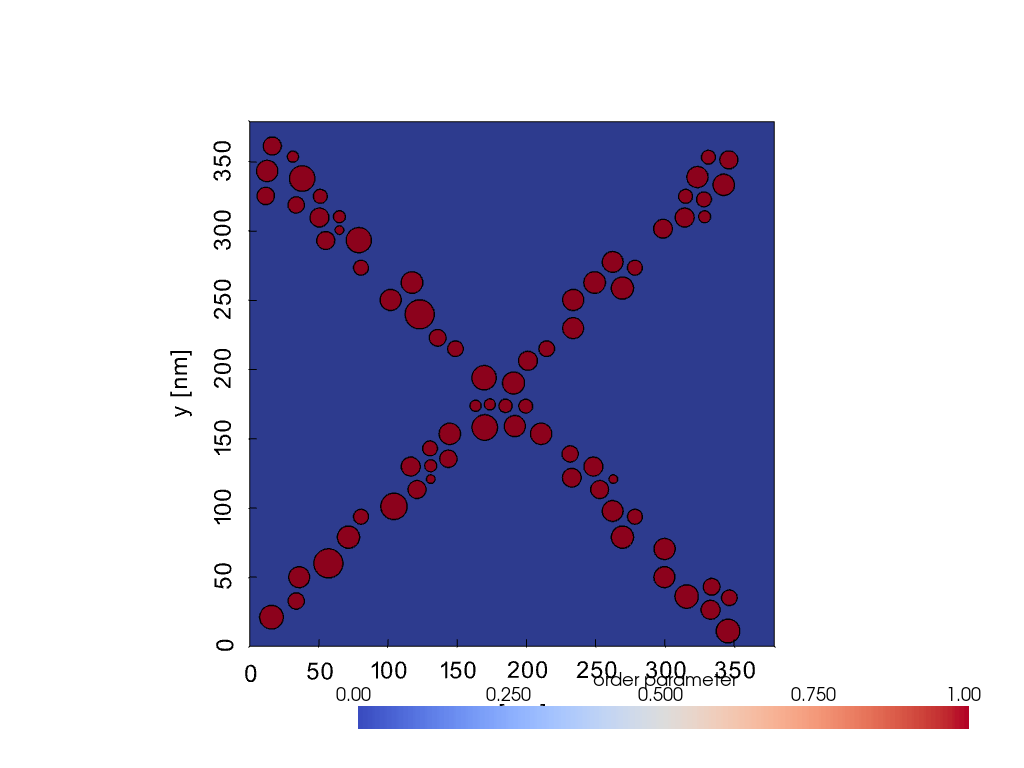

In [131]:
import sys
# grid2 : visualize eta variable
grid2 = pv.UniformGrid()
grid2.spacing=np.array([dx,dy,dz])*1E9
grid2.dimensions = np.array([Nx,Ny,Nz])#+1
grid2.point_arrays[r'order parameter'] = np.transpose(np.resize(eta,[Nx,Ny,Nz])).flatten()  # Flatten the array!

# grid : visualize X variable
grid  = pv.UniformGrid()
grid.spacing=np.array([dx,dx,dx])*1E9
grid.dimensions = np.array([Nx,Ny,Nz])#+1
grid.point_arrays[r"$X_{Si} \ [-]$"] = np.transpose(np.resize(X,[Nx,Ny,Nz])).flatten()

pv.set_plot_theme("document")           # = theme
cmap = plt.cm.get_cmap("coolwarm", 150) # = color map 
# contours for eta variable = 0.1 and 0.9
contours = grid2.contour(isosurfaces=2,rng=([0.1,0.9])) #[0.5, 1]
outline = grid.outline()
p = pv.Plotter()
p.add_mesh(outline, color="k")
p.camera_position = [0, -.75, -1]
p.add_mesh(grid2,cmap=cmap, show_scalar_bar=True,opacity=1.,clim=[0.0,1.])#)#,
p.add_mesh(contours,cmap=cmap, show_scalar_bar=True,color="black") #color="black",,clim=[1.,1.]
p.show_bounds(all_edges=True,xlabel="x [nm]",ylabel="y [nm]",zlabel="z [nm]")
sargs = dict(height=0.1, vertical=False, position_x=0.20, position_y=-0.01)
#p.show(cpos="xy")  # projection plotter.show
p.show(screenshot='initial microstructure.png',cpos="xy")

In [132]:
Meta0_c_Meta=Meta0*c_Meta
gamma_tab2_c_gamma=gamma_tab2*c_gamma
epsX_tab2_c_eps0=epsX_tab2*c_eps0
D0_c_D=D0*c_D
epsX_tab2_c_eps0=epsX_tab2*c_eps0
thresh_step=0

# run the code 

In [133]:
X_out,X_al_out,X_th_out,eta_out,sigel_ij_out,epsel_kl_out,eta_mean_out,deta_mean_out,X_mean_out,X_al_mean_out,dX_al_mean_out,\
          X_th_mean_out,dX_th_mean_out,dT_out,T_out,dtime_out,time_out,surf_out,dsurf_out,el_eta_s,el,G_eta_s,G_ceta_G_cc,L_out,\
           array_energy_s,array_dtime_s,good_step,ttime,array_residus_KKS,array_residus_KKS_energ_deriv,array_residus_KKS_CH,\
                array_residus_KKS_AC, array_residus_KKS_temp_term,array_time_res=\
            pyFi_adapt.main(T_start,Xeq,eta,X ,X_al,X_th,Lv2,tresh,
         Nx,Ny,Nz,dx,dy,dz,\
         temp_tab2,epsX_tab2_c_eps0,D_inter_max_tab2,\
         A_thet_tab2,B_thet_tab2,C_thet_tab2,\
         A_alp_tab2,B_alp_tab2,C_alp_tab2,\
         C11_tab2,C12_tab2,C44_tab2,\
         L_tab2,gamma_tab2_c_gamma,alpha,\
         r_cyl_sor,ox_cyl_sor,oy_cyl_sor,oz_cyl_sor,\
         time_slm_tab1,temp_slm_tab1,X0_mat,X0_pre,\
         Vm_tab2,epsX,dtime_s,nstep,ask_step,ask_step2,\
         D0_c_D,QD,Meta0_c_Meta,QMeta,X_Si_fcc_tab2,lambd,dtime_max,\
         outfile,thresh_step)   

KeyboardInterrupt: 

#### Energy evolution

#### Resilduals evolution

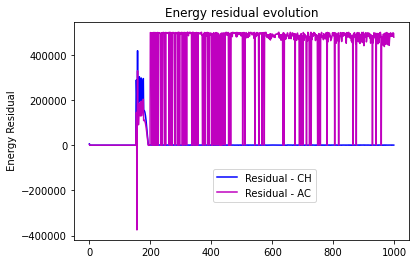

In [52]:
N=50 # pas
plt.plot(array_residus_CH[1:-1:N] , label='Residual - CH', color='b')
#plt.plot(array_energy_deriv[1:-1:N] , label='Energy derivative',color='r')
#plt.plot(array_energy_potentiel_grad[1:-1:N] ,label='Potential gradient functional',color='g')
plt.plot(array_residus_AC[1:-1:N] , label='Residual - AC', color='m')
plt.legend(loc='center left', bbox_to_anchor=(0.4, 0.25))
#plt.xlabel('dimensionless time')
plt.ylabel(' Energy Residual') 
plt.title('Energy residual evolution')
plt.show()


c:\Users\seifa\AppData\Local\Programs\Python\Python310\lib\site-packages\pyvista\core\dataset.py:1458: PyvistaDeprecationWarning: Use of `point_arrays` is deprecated. Use `point_data` instead.
  warnings.warn(
c:\Users\seifa\AppData\Local\Programs\Python\Python310\lib\site-packages\pyvista\plotting\plotting.py:5523: UserWarning: 
Set `jupyter_backend` backend to `"none"` to take a screenshot within a notebook environment.
  warnings.warn(
c:\Users\seifa\AppData\Local\Programs\Python\Python310\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


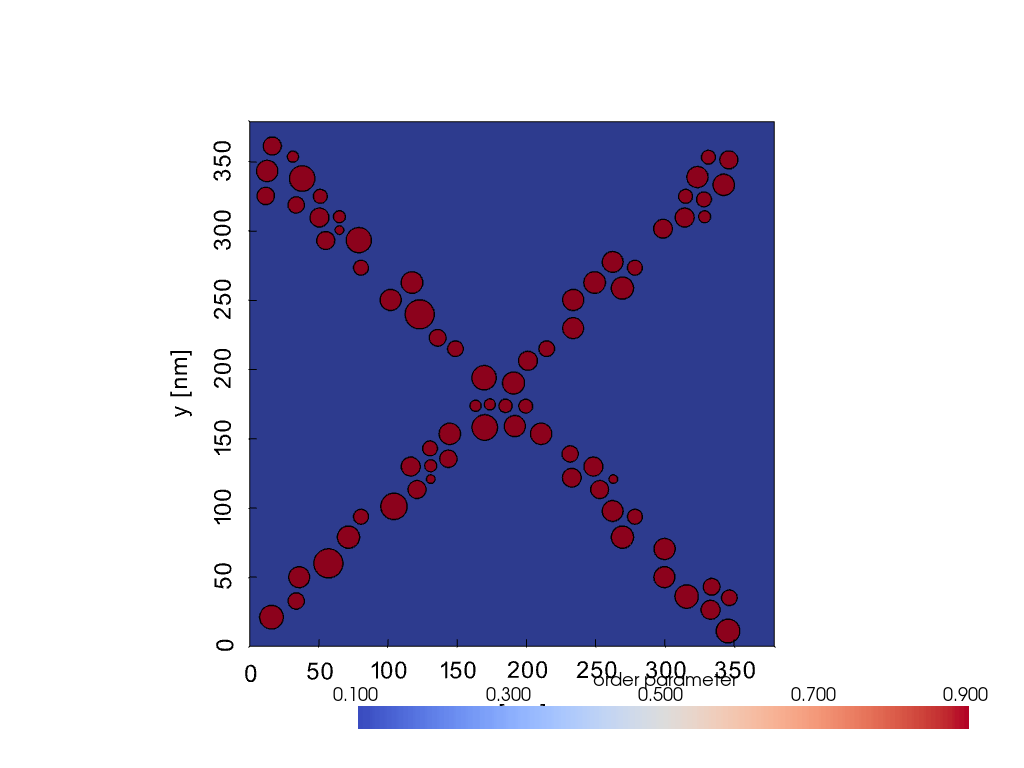

In [53]:
import sys

# grid2 : visualize eta variable
grid2 = pv.UniformGrid()
grid2.spacing=np.array([dx,dy,dz])*1E9
grid2.dimensions = np.array([Nx,Ny,Nz])#+1
grid2.point_arrays[r'order parameter'] = np.transpose(np.resize(eta_out,[Nx,Ny,Nz])).flatten()  # Flatten the array!

# grid : visualize X variable
grid  = pv.UniformGrid()
grid.spacing=np.array([dx,dx,dx])*1E9
grid.dimensions = np.array([Nx,Ny,Nz])#+1
grid.point_arrays[r"$X_{Si} \ [-]$"] = np.transpose(np.resize(eta_out,[Nx,Ny,Nz])).flatten()

pv.set_plot_theme("document")           # = theme
cmap = plt.cm.get_cmap("coolwarm", 150) # = color map 
# contours for eta variable = 0.1 and 0.9
contours = grid2.contour(isosurfaces=2,rng=([0.1,0.9])) #[0.5, 1]
outline = grid.outline()
p = pv.Plotter()
p.add_mesh(outline, color="k")
p.camera_position = [0, -.75, -1]
p.add_mesh(grid2,cmap=cmap, show_scalar_bar=True,opacity=1.,clim=[0.1,0.9])#)#,
p.add_mesh(contours,cmap=cmap, show_scalar_bar=True,color="black") #color="black",,clim=[1.,1.]
p.show_bounds(all_edges=True,xlabel="x [nm]",ylabel="y [nm]",zlabel="z [nm]")
sargs = dict(height=0.1, vertical=False, position_x=0.20, position_y=-0.01)
#p.show(cpos="xy")  # projection plotter.show
p.show(screenshot='actual microstructure.png',cpos="xy")

In [118]:
import free_nrj_mob
importlib.reload(free_nrj_mob) 
from free_nrj_mob import *

In [119]:
eta_s=UnivariateSpline(x=time_out, 
                       y=eta_mean_out, 
                       w=None, bbox=[None, None], k=3, s=5.8e-6, 
                       ext=0, check_finite=False)

In [120]:
X_al_s=UnivariateSpline(x=time_out, 
                       y=X_al_mean_out, 
                       w=None, bbox=[None, None], k=3, s=5.8e-6, 
                       ext=0, check_finite=False)

In [121]:
surf_s=UnivariateSpline(x=time_out , 
                        y=surf_out , 
                        w=None, bbox=[None, None], k=3, s=1.6e-13, 
                        ext=0, check_finite=False)

In [122]:
t_X_al_mod = np.asarray(time_out)[np.asarray(X_al_mean_out)<=0.025]
X_al_mod=np.asarray(X_al_mean_out)[np.asarray(X_al_mean_out)<=0.025]

In [123]:
X_al_mod.shape

(15559,)

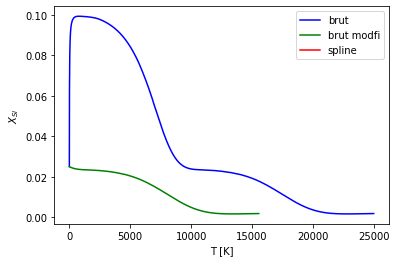

In [124]:
X_al_s=UnivariateSpline(x=t_X_al_mod, 
                       y=X_al_mod, 
                       w=None, bbox=[None, None], k=3, s=5.8e-6, 
                       ext=0, check_finite=False)

plt.plot(X_al_mean_out,color="b",label="brut")
 
plt.plot(X_al_mod,color="g",label="brut modfi")
plt.plot(X_al_s(t),color="r",label="spline")

plt.xlabel("T [K]")
plt.ylabel(r"$X_{Si}$")
 
plt.legend()

In [125]:
deta_dt_s  = eta_s.derivative(n=1)(time_out)
dX_al_dt_s = X_al_s.derivative(n=1)(time_out)
dsurf_dt_s  = surf_s.derivative(n=1)(time_out)

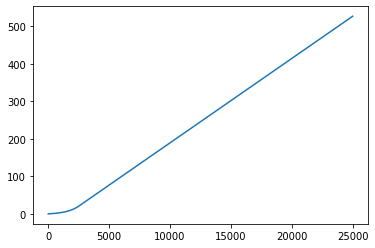

In [127]:
plt.plot(time_out)

In [ ]:
"""
time_out=np.asarray(time_out)
surf=np.asarray(surf_out)
t_surf_mod = time_out[time_out>=150]
surf_mod=surf[time_out>=150]

surf_mod2 = np.hstack(( 0.,5e-8, surf_mod))
t_surf_mod2 = np.hstack(( 0,75, t_surf_mod))

surf_s=UnivariateSpline(x=t_surf_mod , 
                        y=surf_mod, 
                        w=None, bbox=[None, None], k=2, s=1.6e-15, 
                        ext=0, check_finite=False)




dsurf_dt_s  = surf_s.derivative(n=1)(t)

plt.plot(time_out*(1/3)+400, surf ,label="brut")
plt.plot(t_surf_mod2*(1/3)+400, surf_mod2,color="g",label="brut modfi")

#plt.plot(t,surf)
plt.plot(T,surf_s(t),color="r",label="spline")

plt.xlabel("T [K]")
plt.ylabel(r"$surf$")

plt.legend()
"""

'\ntime_out=np.asarray(time_out)\nsurf=np.asarray(surf_out)\nt_surf_mod = time_out[time_out>=150]\nsurf_mod=surf[time_out>=150]\n\nsurf_mod2 = np.hstack(( 0.,5e-8, surf_mod))\nt_surf_mod2 = np.hstack(( 0,75, t_surf_mod))\n\nsurf_s=UnivariateSpline(x=t_surf_mod , \n                        y=surf_mod, \n                        w=None, bbox=[None, None], k=2, s=1.6e-15, \n                        ext=0, check_finite=False)\n\n\n\n\ndsurf_dt_s  = surf_s.derivative(n=1)(t)\n\nplt.plot(time_out*(1/3)+400, surf ,label="brut")\nplt.plot(t_surf_mod2*(1/3)+400, surf_mod2,color="g",label="brut modfi")\n\n#plt.plot(t,surf)\nplt.plot(T,surf_s(t),color="r",label="spline")\n\nplt.xlabel("T [K]")\nplt.ylabel(r"$surf$")\n\nplt.legend()\n'

In [129]:
deta_dt_s  = eta_s.derivative(n=1)(t)
dX_al_dt_s = X_al_s.derivative(n=1)(t)

In [130]:
T=T_out
t=time_out
cp_fcc = np.zeros(len(T))
cp_dia = np.zeros(len(T))
Hm_dia = np.zeros(len(T))
Hm_fcc = np.zeros(len(T))
Vm_dia = np.zeros(len(T))
Vm_fcc = np.zeros(len(T))
d_Hm_fcc_dSi = np.zeros(len(T))

In [131]:
for i in range(len(T)):
    cp_fcc[i] = gibbs_energy(T=T[i], X_Si=X_al_s(t[i]), output ="cp_fcc" )
    Hm_fcc[i] = gibbs_energy(T=T[i], X_Si=X_al_s(t[i]), output ="Hm_fcc" )
    cp_dia[i] = gibbs_energy(T=T[i], X_Si=0.9999, output ="cp_dia" )
    Hm_dia[i] = gibbs_energy(T=T[i], X_Si=0.9999, output ="Hm_dia" )
    Vm_dia[i] = molar_volume(T0=298, T=T[i],X_Si=0.9999, output ="Vmdia" )
    Vm_fcc[i] = molar_volume(T0=298, T=T[i],X_Si=X_al_s(t[i]), output ="Vmfcc" )
    d_Hm_fcc_dSi[i] = gibbs_energy(T=T[i], X_Si=X_al_s(t[i]), output ="d_Hm_fcc_dSi" )

In [132]:
T_dot = 20/60   # K.s-1
umAl = 26.98154 # g.mol-1
umSi = 28.0855  # g.mol-1
gam_H = 1.5     # J.m-1

In [133]:
V_sim = (400e-9)**2   # m2  
rho_alloy = eta_s(t)*umSi/Vm_dia + (1-eta_s(t))*umAl/Vm_fcc # g.m-3

In [134]:
dsc_bkg = T_dot*(eta_s(t)*cp_dia*(1/umSi)+(1-eta_s(t))*cp_fcc*(1/umAl))


dsc_surf = gam_H*dsurf_dt_s/(V_sim*rho_alloy)  # 

dsc_preci = (1-eta_s(t))*d_Hm_fcc_dSi*(1/umAl)*dX_al_dt_s+\
             deta_dt_s*(Hm_dia*(1/umSi))+(-deta_dt_s)*(Hm_fcc*(1/umAl))

(500.0, 550.0)

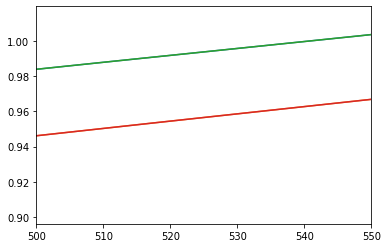

In [135]:
plt.plot(T_out,dsc_bkg*3)
plt.plot(T,(dsc_bkg+dsc_preci)*3)

plt.plot(T,(dsc_bkg+dsc_surf)*3)

plt.plot(T,(dsc_bkg+dsc_surf+dsc_preci)*3)

plt.xlim([500,550])

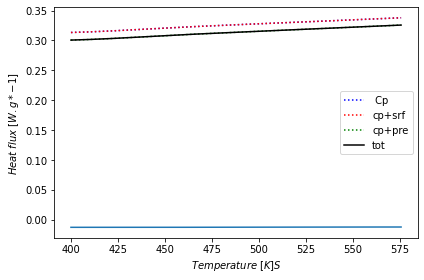

In [136]:
plt.plot (T_out,dsc_bkg,linestyle=":",color="b",label=" Cp") ##dsc surf
plt.plot(T_out,dsc_bkg+dsc_surf,linestyle=":",color="r",label="cp+srf") #+dsc surf
plt.plot(T_out,dsc_bkg+dsc_preci,linestyle=":",color="g",label="cp+pre") #+dsc surf
plt.plot(T_out,dsc_preci+dsc_surf+dsc_bkg,linestyle="-",color="k",label="tot") #+dsc surf


plt.ylabel(r"$Heat \ flux \ [W.g*{-1}]$")

plt.xlabel(r"$Temperature \ [K]S$")
  
plt.plot(T_out,dsc_preci+dsc_surf)#tdsc surf

#plt.plot(T out,dsc surf)

#plt.xlim([400,401])

#plt.ylim([0.22,0.35])

plt.legend()

plt.tight_layout ()